# ISP Pipeline Homework
### Will be taking RAW image from Nikon D3400 and processing into finished image

In [38]:
# Import necessary modules into notebook
!pip3.11 install numpy pandas scikit-image colour_demosaicing
from skimage.io import imread, imsave
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
from colour_demosaicing import demosaicing_CFA_Bayer_bilinear
import os

### RAW image conversions
- Black scaling: 0
- White scaling: 16383
- Red scaling: 1.628906
- Green scaling: 1.00000
- Blue scaling: 1.386719

In [39]:
BLACK = 0
WHITE = 16383
RED = 1.628906
GREEN = 1.00000
BLUE = 1.386719

### Reading file into Memory
Using *skimage* library and *numpy*, we will take RAW image and turn it into a numpy 2D-array of unsigned integers. Then convert the image into a double-precision array.

Bits Per Pixel: 16, Width: 4284, Height: 2844


New 2D array type: float64


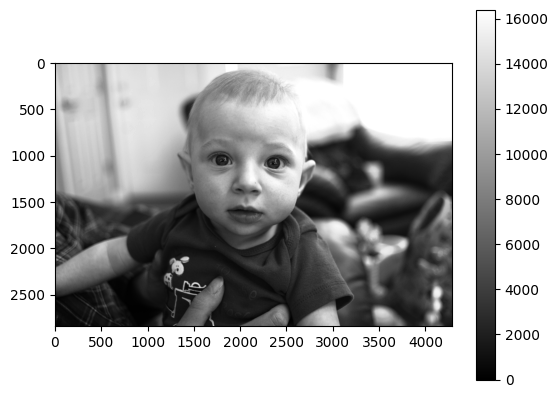

In [40]:
raw_image = imread("data/baby.tiff")
# raw_iamge.dtype.itemsize returns the number of bytes of each element in the array
# in our case it is 2 bytes representing an unsigned 16 bit integer
bits_per_pixel = raw_image.dtype.itemsize * 8
print(f"Bits Per Pixel: {bits_per_pixel}, Width: {len(raw_image[0])}, Height: {len(raw_image)}")

# no named double type but its just a floating point with 64 bits, so we sue float64
raw_image_double = raw_image.astype(np.float64)
print(f"New 2D array type: {raw_image_double.dtype}")

plt.imshow(np.clip(raw_image_double * 5, 0, WHITE), cmap="gray")
plt.colorbar()
plt.show()

def display_plot(image, name, clip, color = False):
    if color:
        plt.imshow(np.clip(image * 5, 0, clip))
    else:
        plt.imshow(np.clip(image * 5, 0, clip), cmap="gray")
    plt.title(name)
    plt.colorbar()
    plt.show()

### Linearization
Convert the image into a linear array from [0, 1] based on [WHITE, BLACK] and clip off any value that were less than the black and greater than white from the reconnaissance run of *dcraw*.

RAW image min: 0.0, RAW image max: 16383.0
Linearized min: 0.0, Linearized max: 1.0


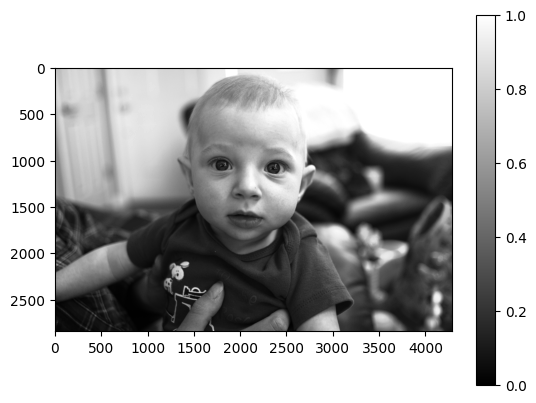

In [41]:
scaled_image = (raw_image_double - BLACK) / (WHITE - BLACK)
linearized_image = np.clip(scaled_image, 0, 1)
print(f"RAW image min: {np.min(raw_image_double)}, RAW image max: {np.max(raw_image_double)}")
print(f"Linearized min: {np.min(linearized_image)}, Linearized max: {np.max(linearized_image)}")

plt.imshow(np.clip(linearized_image * 5, 0, 1), cmap="gray")
plt.colorbar()
plt.show()

### Identifiying the correct Bayer pattern
First to determine which orientation the green is in we can look at the first 4 by 4 pixels and see is it g\*\*g or \*gg\* because the pixels are close together so the green filter will have very similar values. The code below shows us the green orientation is \*gg\* and now we need to differentiate between blue and green.

To do this I selected a part of the image that was predominately red and sampled rows from that region. I then removed the green pixels that were identified and separated the sample into even rows and odd rows, where even rows represent the top left pixel in the 4 by 4 group and odd rows represent the bottom right pixel. We see that the even rows have a higher average, so we can say that those rows are red. So our pattern is "rggb".

In [42]:
four_by_four_block = linearized_image[2000:2004, 1200:1204]
print(four_by_four_block)

sampled_pixels = linearized_image[2000:2200]
even_rows = sampled_pixels[::2, 1200:2000]
odd_rows = sampled_pixels[1::2, 1200:2000]

even_rows_removed_green =  even_rows[:, ::2]
odd_rows_removed_green =  odd_rows[:, 1::2]
print("Even rows without green average: ", even_rows_removed_green.mean())
print("Odd rows without green average: ", odd_rows_removed_green.mean())

[[ 0.04217787  0.01037661  0.03808826  0.01281817]
 [ 0.01306232  0.01141427  0.01135323  0.0087896 ]
 [ 0.03637917  0.01220778  0.03491424  0.01043765]
 [ 0.01312336  0.00683635  0.01080388  0.00824025]]
Even rows without green average:  0.0456272828542
Odd rows without green average:  0.0183565906733


### White balancing
Will implementing this by creating a 2D filter that will scale the values of red, green, and blue by the scale given by the reconnaissance run.

#### White World White Balancing Algorithm

In [43]:
# White World White Balancing

# Find the maximum value of each color channel
red_max = np.max(linearized_image[::2, ::2])
green_max = np.max(np.maximum(linearized_image[::2, 1::2], linearized_image[1::2, ::2]))
blue_max = np.max(linearized_image[1::2, 1::2])

# Calculate the scaling factors for each color channel
max_value = np.max([red_max, green_max, blue_max])
red_scale = max_value / red_max
green_scale = max_value / green_max
blue_scale = max_value / blue_max

# Apply the scaling factors to the image
white_world_balanced_image = np.copy(linearized_image)
white_world_balanced_image[::2, ::2] *= red_scale
white_world_balanced_image[::2, 1::2] *= green_scale
white_world_balanced_image[1::2, ::2] *= green_scale
white_world_balanced_image[1::2, 1::2] *= blue_scale

print(f"Red scaling factor: {red_scale}, Green scaling factor: {green_scale}, Blue scaling factor: {blue_scale}")

# Normalize the white-balanced image back to the range [0, 1]
white_world_balanced_image = np.clip(white_world_balanced_image, 0, 1)



Red scaling factor: 1.0, Green scaling factor: 1.002815694435943, Blue scaling factor: 1.0


#### Grey World White Balancing Algorithm

In [44]:
red_avg = np.mean(linearized_image[::2, ::2])
green_avg = np.mean(linearized_image[::2, 1::2] + linearized_image[1::2, ::2]) / 2
blue_avg = np.mean(linearized_image[1::2, 1::2])

total_avg = (red_avg + green_avg + blue_avg) / 3

grey_world_balanced_image = np.copy(linearized_image)
grey_world_balanced_image[::2, ::2] *= total_avg / red_avg
white_world_balanced_image[::2, 1::2] *= total_avg / green_avg
white_world_balanced_image[1::2, ::2] *= total_avg / green_avg
grey_world_balanced_image[1::2, 1::2] *= total_avg / blue_avg

print(f"Red scaling factor: {total_avg / red_avg}, Green scaling factor: {total_avg / green_avg}, Blue scaling factor: {total_avg / blue_avg}")

grey_world_balanced_image = np.clip(grey_world_balanced_image, 0, 1)

Red scaling factor: 1.1458571910308346, Green scaling factor: 0.8504010158361683, Blue scaling factor: 1.051110138592342


#### Balancing using RGB channel values from reconnaissance run

In [45]:
# white_balancing_kernel = np.array([[RED, GREEN], [GREEN, BLUE]], dtype=np.float64)
# white_balanced_image = linearized_image @ white_balancing_kernel

white_balanced_image = linearized_image.copy()
white_balanced_image[::2, ::2] = linearized_image[::2, ::2] * RED
white_balanced_image[1::2, 1::2] = linearized_image[1::2, 1::2] * BLUE

white_balanced_image

array([[ 0.17449368,  0.1833608 ,  0.16942293, ...,  0.99658182,
         1.04596784,  0.99536104],
       [ 0.18342184,  0.20771583,  0.19251663, ...,  1.37656175,
         0.99572728,  1.37656175],
       [ 0.1678321 ,  0.1855582 ,  0.17001949, ...,  0.99658182,
         1.03194869,  0.99530001],
       ..., 
       [ 0.01831166,  0.01946807,  0.01220778, ...,  0.00998797,
         0.02655191,  0.00821045],
       [ 0.01312431,  0.01281817,  0.01978589, ...,  0.02435451,
         0.02376296,  0.02642984],
       [ 0.01031557,  0.01286585,  0.00866752, ...,  0.0102419 ,
         0.02520906,  0.0102419 ]])

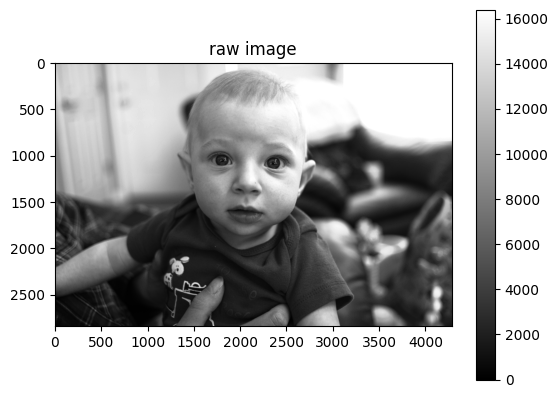

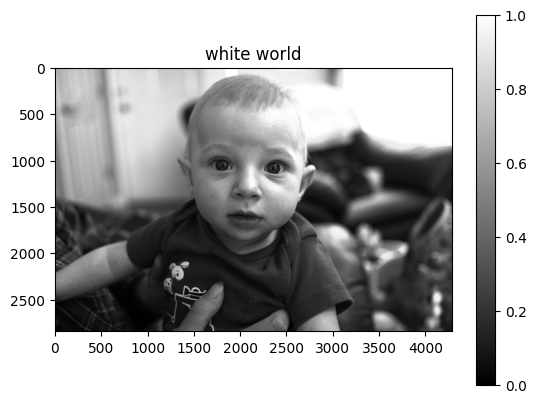

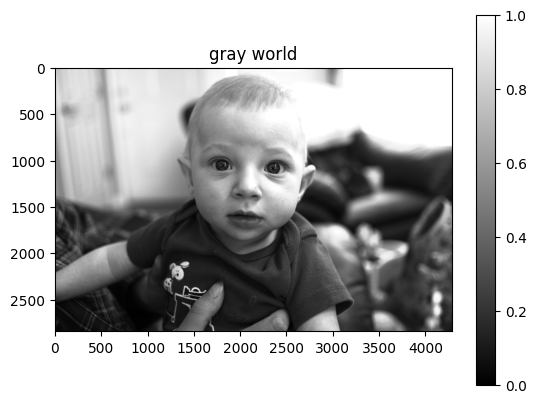

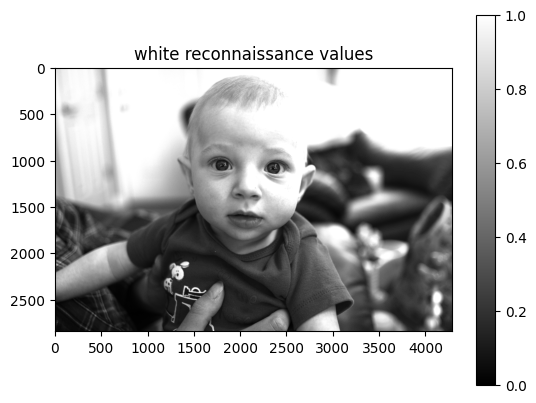

In [46]:
display_plot(raw_image_double, "raw image", WHITE)
display_plot(white_world_balanced_image, "white world", 1)
display_plot(grey_world_balanced_image, "gray world", 1)
display_plot(white_balanced_image, "white reconnaissance values", 1)
# fig = plt.figure()
# fig.add_subplot(2, 2, 1)
# plt.imshow(raw_image_double, cmap="gray")
# fig.add_subplot(2, 2, 2)
# plt.imshow(linearized_image, cmap="gray")
# fig.add_subplot(2, 2, 3)
# plt.imshow(white_world_balanced_image, cmap="gray")
# fig.add_subplot(2, 2, 4)
# plt.imshow(white_balanced_image, cmap="gray")
# plt.show()

### Demosaicing
Use scipy's built-in interp2d function to do bilinear interpolation

(2844, 4284, 3)
(2844, 4284, 3)


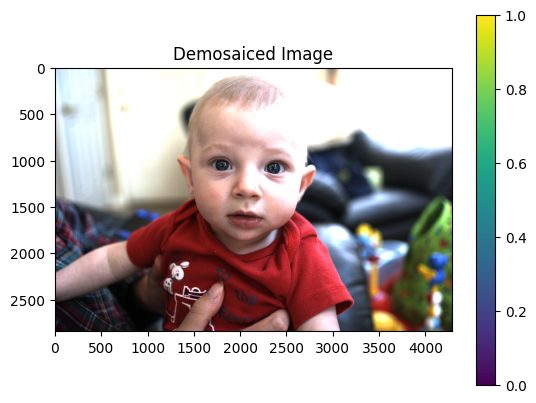

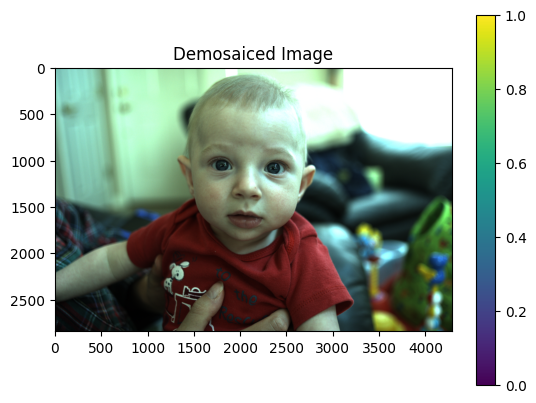

In [47]:
bayer_pattern = "RGGB"

demosaiced_image = demosaicing_CFA_Bayer_bilinear(white_balanced_image, bayer_pattern)
demosaiced_image_2 = demosaicing_CFA_Bayer_bilinear(white_world_balanced_image, bayer_pattern)

print(demosaiced_image.shape)
print(demosaiced_image_2.shape)

display_plot(demosaiced_image, "Demosaiced Image", 1, True)
display_plot(demosaiced_image_2, "Demosaiced Image", 1, True)

### Color Space Correction

Calculate the sRGB to CAM matrix and then use the inverse to get the correct image in the color space we needed.

In [48]:
sRGBtoXYZ = np.asmatrix([
    [0.4124564, 0.3575761, 0.1804375], 
    [0.2126729, 0.7151522, 0.0721750], 
    [0.0193339, 0.1191920, 0.9503041]
    ])

XYZtoCAM = np.asmatrix([
    [6988, -1384, -714], 
    [-5631, 13410, 2447], 
    [-1485, 2204, 7318]
    ])

sRGBtoCAM = XYZtoCAM @ sRGBtoXYZ

row_sums = sRGBtoCAM.sum(axis=1)
sRGBtoCAM_normalized = sRGBtoCAM / row_sums

print(sRGBtoCAM_normalized)

sRGBtoCAM_inverse= np.linalg.inv(sRGBtoCAM_normalized)

corrected_image = np.zeros_like(demosaiced_image, dtype=np.float32)

for y in range(demosaiced_image.shape[0]):
        for x in range(demosaiced_image.shape[1]):
            pixel = demosaiced_image[y, x]
            corrected_pixel = np.dot(sRGBtoCAM_inverse, pixel)
            corrected_image[y, x] = corrected_pixel

[[  5.74517316e-01   3.17795088e-01   1.07687596e-01]
 [  5.37863305e-02   7.33831689e-01   2.12381981e-01]
 [ -2.60393071e-04   2.18870826e-01   7.81389567e-01]]


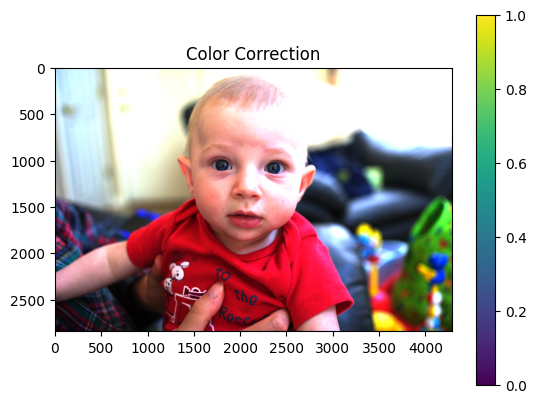

3.8360393

In [49]:
display_plot(corrected_image, "Color Correction", 1, True)
np.max(corrected_image)

### Brightness Encoding and Gamma Encoding

In [50]:
def adjust_brightness(image, desired_mean=0.25):
    # Convert to grayscale and compute current mean
    grayscale = rgb2gray(image)
    current_mean = np.mean(grayscale)
    
    # Calculate scaling factor
    scaling_factor = desired_mean / current_mean
    
    # Scale and clip the image
    adjusted_image = image * scaling_factor
    adjusted_image = np.clip(adjusted_image, 0, 1)
    
    return adjusted_image

def srgb_tonemap(values):
    values = np.clip(values, 0, 1)
    mask = values <= 0.0031308
    values[mask] *= 12.92
    values[~mask] = (1 + 0.055) * np.power(values[~mask], 1/2.4) - 0.055
    return values

def gamma_encoding(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    r_encoded = srgb_tonemap(r)
    g_encoded = srgb_tonemap(g)
    b_encoded = srgb_tonemap(b)
    
    encoded_image = np.dstack((r_encoded, g_encoded, b_encoded))
    return encoded_image

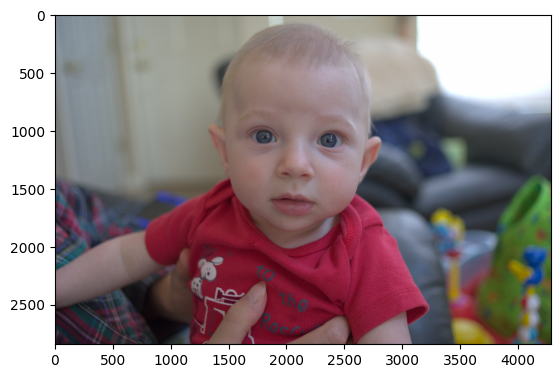

[[[ 0.9691443   0.337739    0.29552788]
  [ 0.6780108   0.66602254  0.3162398 ]
  [ 0.7403256   0.48760092  0.40146473]
  ..., 
  [ 0.99999994  0.99999994  0.85667056]
  [ 0.99999994  0.9774577   0.99999994]
  [ 0.61011505  0.99999994  0.99999994]]

 [[ 0.67563474  0.6663397   0.31601253]
  [ 0.51535004  0.54901636  0.59619945]
  [ 0.5060847   0.564446    0.5865449 ]
  ..., 
  [ 0.99999994  0.99999994  0.99999994]
  [ 0.99999994  0.99999994  0.99999994]
  [ 0.67401433  0.64045846  0.99999994]]

 [[ 0.73719484  0.48255908  0.41052544]
  [ 0.51180947  0.54671556  0.60016984]
  [ 0.5095331   0.5583159   0.59186417]
  ..., 
  [ 0.99999994  0.99999994  0.99999994]
  [ 0.99999994  0.99999994  0.99999994]
  [ 0.          0.99999994  0.99999994]]

 ..., 
 [[ 0.20203605  0.22395864  0.07579152]
  [ 0.16436046  0.14592326  0.19342622]
  [ 0.17899325  0.1259943   0.17825127]
  ..., 
  [ 0.1942048   0.2413376   0.06428116]
  [ 0.18561009  0.24717283  0.03939543]
  [ 0.07355779  0.20732525  0.11803

In [51]:
adjusted_image = adjust_brightness(corrected_image)
final_image = gamma_encoding(adjusted_image)

plt.imshow(final_image)
plt.show()

print(final_image)

### Output images in different formats and qualities

In [52]:
final_image_uint8 = (final_image * 255).astype(np.uint8)
imsave('image_recon.png', final_image_uint8)
imsave('image_recon.jpeg', final_image_uint8, format="jpeg", quality=95)

In [53]:
imsave("image2_recon.jpeg", final_image_uint8, format="jpeg", quality=75)

In [54]:
imsave("image3_recon.jpeg", final_image_uint8, format="jpeg", quality=40)

In [55]:
# Get the file sizes in bytes
png_size = os.path.getsize('image.png')
jpeg_size = os.path.getsize('image3.jpeg')

# Print the file sizes
print(f"PNG file size: {png_size} bytes")
print(f"JPEG file size (quality 95): {jpeg_size} bytes")

# Calculate the compression ratio
compression_ratio = png_size / jpeg_size

print(f"Compression ratio (PNG / JPEG quality 95): {compression_ratio:.2f}")

PNG file size: 15595198 bytes
JPEG file size (quality 95): 318132 bytes
Compression ratio (PNG / JPEG quality 95): 49.02
